In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 429, 30, 16)       160       
_________________________________________________________________
leaky_re_lu_180 (LeakyReLU)  (None, 429, 30, 16)       0         
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 215, 15, 16)       0         
_________________________________________________________________
batch_normalization_120 (Bat (None, 215, 15, 16)       64        
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 213, 13, 16)       2320      
_________________________________________________________________
leaky_re_lu_181 (LeakyReLU)  (None, 213, 13, 16)       0         
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 107, 7, 16)      

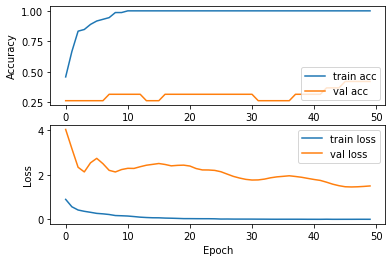

Sample: 1
Probability: [[0.86805445]]
Predicted: NO BIRD?, Expected: NO BIRD!, File: 70326.wav
Sample: 2
Probability: [[0.17688923]]
Predicted: BIRD?, Expected: BIRD!, File: 51b06cca-a5aa-40fd-9091.wav
1/1 - 0s - loss: 0.9130 - accuracy: 0.5217

Test accuracy: 0.52173912525177
Ideal threshold is:  7    0.708496
Name: thresholds, dtype: float32
Area under curve, AUC =  0.5166666666666666


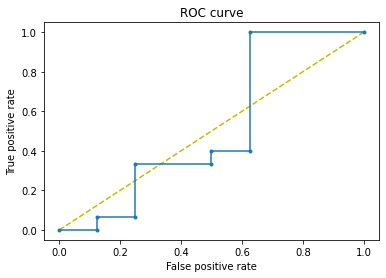

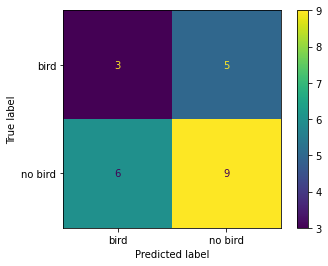

In [39]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd

DATA_PATH = '/content/drive/My Drive/MSc_Project_Colab/mixed_114_32mels_filenames.json'


def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["log mel spectrogram"])
    y = np.array(data["labels"])
    z = np.array(data["filenames"])
    return X, y, z


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train acc")
    axs[0].plot(history.history["val_accuracy"], label="val acc")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[0].legend(loc="lower right")
    # axs[0].set_title("Accuracy")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train loss")
    axs[1].plot(history.history["val_loss"], label="val loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    # axs[1].set_title("Loss")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y, z = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=test_size, random_state=1)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=1)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z_train, z_test


def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(16, (3, 3), input_shape=input_shape))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(16, (3, 3), input_shape=input_shape))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(16, (1, 3), input_shape=input_shape))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(keras.layers.MaxPool2D((1, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 4th conv layer
    model.add(keras.layers.Conv2D(16, (1, 3), input_shape=input_shape))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(keras.layers.MaxPool2D((1, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed to dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    # model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(32))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    # model.add(keras.layers.Dropout(0.4))


    # output layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    return model


def predict(model, X, y, z):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    

    # perform prediction
    prediction = model.predict(X)

    print("Probability: {}".format(model.predict(X)))

    thresh = 0.5

    if  y == 0:
        dataLabel = "BIRD!"
    else:
        dataLabel = "NO BIRD!"

    if model.predict(X)<= thresh:
        myPrediction = "BIRD?"
    else:
        myPrediction = "NO BIRD?"

    print("Predicted: {}, Expected: {}, File: {}".format(myPrediction, dataLabel, z))


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test, z_train, z_test = prepare_datasets(0.2, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimiser,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=64, epochs=50)

    # plot accuracy/error for training and validation
    plot_history(history)

    
    # make prediction on a sample
    for index in range(int(len(X_test) / 10)):
        X = X_test[index]
        y = y_test[index]
        z = z_test[index]
        print("Sample: {}".format(index+1))
        predict(model, X, y, z)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # ROC
    # print("X_test pre ravel: {}".format(X_test.shape))
    y_preds = model.predict(X_test).ravel()
    # print("X_test post ravel: {}".format(X_test.shape))

    fpr, tpr, thresholds = roc_curve(y_test, y_preds)
    # print("fpr: {}, tpr: {}".format(fpr, tpr))
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'y--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show

    #One way to find the best threshold once we calculate the true positive 
    # and false positive rates is ...
    # The optimal cut off point would be where “true positive rate” is high 
    # and the “false positive rate” is low. 
    # Based on this logic let us find the threshold where tpr-(1-fpr) is zero (or close to 0)
    
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
    ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
    print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

    #Now use this threshold value in the confusion matrix to visualize the balance
    #between tp, fp, fp, and fn

    # AUC
    from sklearn.metrics import auc
    auc_value = auc(fpr, tpr)
    print("Area under curve, AUC = ", auc_value)

    # confusion matrix
    my_threshold = 0.5

    y_pred = (model.predict(X_test)>= my_threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    # print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["bird", "no bird"])
    disp.plot() 

    


